Projective sampling integrators
===============================

## Overview 

In this tutorial, we will optimize a curve such that its shadows match some target reference. We will do this by only observing the shadows and making use of the the projective sampling integrators.

Gradients introduced by indirect visibilty effects, such as shadows or reflections are difficult to capture. In previous tutorials, we mentioned how discontinuities require special care and that Mitsuba 3 uses a "projective sampling"-based method to handle these. Here, we will dig deeper into the integrators that implement this method:

- [<code>direct_projective</code>][1]
- [<code>prb_projective</code>][2]

More details about this projective sampling method can be found in the paper "[Projective Sampling for Differentiable Rendering of Geometry][3]".

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**
    
<ul>
  <li>Use the projective sampling integrators</li>
  <li>Use the `batch` sensor to render multiple points of view at the same time</li>
</ul>
    
</div>

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#direct-illumination-projective-sampling-direct-projective
[2]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#projective-sampling-path-replay-backpropagation-prb-prb-projective
[3]: http://rgl.epfl.ch/publications/Zhang2023Projective

## Setup

As always, let's start by importing `drjit` and `mitsuba` and set a differentiation-aware variant.

In [1]:
import drjit as dr
import mitsuba as mi
import numpy as np
import os

mi.set_variant('cuda_ad_rgb')

## Scene

We want to cast two distinct shadows from a single object and have the shadows form specific shapes. More specifically, we'll be optimizing a 3D curve using the [<code>bsplinecurve</code>][1] plugin such that its two shadows "draw" a moon and a star.

We provide you with a pre-built scene in a XML file, we just need to load it. Let's also render it.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_shapes.html#b-spline-curve-bsplinecurve

In [2]:
scene = mi.load_file('../scenes/shadow_art.xml')
image_scene = mi.render(scene, spp=4096)
mi.Bitmap(image_scene)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 128],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 384 KiB of image data ]
]

At the bottom, you can see our curve shape that we've wrapped on itself to create a circle. In the top left and top right, there are the two shadows that were casted by the curve onto two separate walls. We can't see the emitters from this point of view, as they are both slightly behind the sensor's viewpoint.

For the purposes of this tutorial, we will only be considering the shadows themselves during the optimization. We should therefore build two sensors that respectively look straight at the left and right wall. Neither sensor should see the curve directly. For convenience, Mitsuba ships with a [<code>batch</code>][1] sensor, which renders multiple views at once. There is a performance benefit to this approach: the just-in-time compiler only needs to trace the rendering process once instead of multiple times (once for each viewpoint).

With the [<code>batch</code>][1] sensor, the rendered output is a single image of all viewpoints stitched together horizontally.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_sensors.html#batch-sensor-batch

In [3]:
dist = 5
batch_sensor = mi.load_dict({
    'type': 'batch',
    'sensor1': {
        'type': 'perspective',
        'fov': 100,
        'to_world': mi.ScalarTransform4f.look_at(
            origin=[0, 0, -dist + 1],
            target=[0, 0, -dist],
            up=[0, 1, 0]
        ),
    },
    'sensor2': {
        'type': 'perspective',
        'fov': 100,
        'to_world': mi.ScalarTransform4f.look_at(
            origin=[-dist + 1, 0, 0],
            target=[-dist, 0, 0],
            up=[0, 1, 0]
        ),
    },
    'film': {
        'type': 'hdrfilm',
        'width': 128 * 2,
        'height': 128,
        'sample_border': True,
        'filter': { 'type': 'box' }
    },
    'sampler': {
        'type': 'independent',
        'sample_count': 256
    }
})

image_primal = mi.render(scene, sensor=batch_sensor, spp=4096)
mi.Bitmap(image_primal)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 128],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 384 KiB of image data ]
]

## Reference image

We can now load the reference image (by [Ziyi Zhang][1]). As mentionned previously, our goal is to reconstruct a star and moon outline with the shadows. Keep in mind that although the image shows both outlines next to each other, they will be on separate walls in our scene.

Note that if you want use your own reference image, you should carefully match the pixel values of the initial images (wall and shadow values).

[1]: http://rgl.epfl.ch/people/ziyi

In [4]:
bitmap_ref = mi.Bitmap('../scenes/references/starmoon.exr')
image_ref = mi.TensorXf(bitmap_ref)

# Reshape into [height, widht, 1]
resolution = bitmap_ref.size()
image_ref = mi.TensorXf(image_ref.array, shape=[resolution[1], resolution[0], 1])

bitmap_ref

Bitmap[
  pixel_format = y,
  component_format = float32,
  size = [256, 128],
  srgb_gamma = 0,
  struct = Struct<4>[
    float32 Y; // @0, premultiplied alpha
  ],
  metadata = {
    generatedBy => "Mitsuba version 3.4.0",
    pixelAspectRatio => 1,
    screenWindowWidth => 1
  },
  data = [ 128 KiB of image data ]
]

## Projective sampling integrator

In this section, we will go over some of the options/parameters that are availble in the projective sampling integrators. We will see how they impact the quality of the gradients.

### Finite differences

We assess the quality of our gradients by comparing them against a ground truth measurement using finite differences. As was mentioned in previous tutorials, visualizing forward gradients is a nice method to get a better understanding of how some change in a parameter will change the rendered output.

To capture a forward-mode gradient image, we must apply some change to our scene. Here, we arbitraily chose to look at a rotation aound the Y axis (vertical axis) of the [<code>bsplinecurve</code>][1] object

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_shapes.html#b-spline-curve-bsplinecurve

In [5]:
key = 'curve.control_points'
params = mi.traverse(scene)
initial_control_points = mi.Float(params[key])

def apply_y_rotation(params, value):
    control_points = dr.unravel(mi.Point4f, params[key])
    radii = control_points[3]
    points = mi.Point3f(control_points.x, control_points.y, control_points.z)
    
    rotation = mi.Transform4f.rotate([0, 1, 0], value)
    rotated_points = rotation @ points
    new_control_points = mi.Point4f(rotated_points.x, rotated_points.y, rotated_points.z, radii)
    
    params[key] = dr.ravel(new_control_points)
    params.update()

We render the finite differences gradient estimate in  multiple rounds with different seeds to avoid exceeding the maximum number of samples in a single kernel. In total we are using approximately 4.3 billion samples.

In [6]:
epsilon = 1e-3
fd_spp = 2048
fd_repeat = 32 if 'PYTEST_CURRENT_TEST' not in os.environ else 1
res = batch_sensor.film().size()
img1 = dr.zeros(mi.TensorXf, (res[1], res[0], 3))
img2 = dr.zeros(mi.TensorXf, (res[1], res[0], 3))

for it in range(fd_repeat):
    apply_y_rotation(params, -epsilon)
    img1 += mi.render(scene, sensor=batch_sensor, spp=fd_spp, seed=it)
    params[key] = initial_control_points # Undo translation
    params.update()
    
    apply_y_rotation(params, +epsilon)
    img2 += mi.render(scene, sensor=batch_sensor, spp=fd_spp, seed=it)
    params[key] = initial_control_points # Undo translation
    params.update()
    
    print(f"{it+1}/{fd_repeat}", end='\r')
    
img_fd = (img2 - img1) / (epsilon*2) / fd_repeat

We can now visualize the sum of all 3 channels' gradients. In the plot below, warmer colors indicate an increase in pixel value and colder values a decrease.

We can see how the shadow on the left is becoming thinner, whereas the one on the right is becoming larger. This is expected as the circle will become more perpendicular to the wall in one case and more parallel in the other.

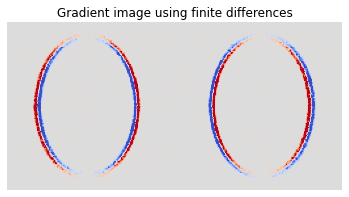

In [7]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

vlim = dr.max(dr.abs(img_fd))[0] * 1
plt.imshow(np.sum(img_fd, axis=2), cmap=cm.coolwarm, vmin=-vlim, vmax=vlim)
plt.title("Gradient image using finite differences")
plt.axis('off')
plt.show()

### The `direct_projective` integrator

The [<code>direct_projective</code>][1] plugin has many parameters which allow us to fine tune its performance and use cases:

* `sppc`: number of samples per pixel used to estimate the continuous derivatives
* `sppp`: number of samples per pixel used to estimate the gradients resulting from primary visibility changes
* `sppi`: number of samples per pixel used to estimate the gradients resulting from indirect visibility changes
* `guiding`: the type of guiding method used to estimate the indirect visibility derivatives 
* `guiding_proj`: whether or not to use projective sampling to build the guiding structure

Internally, the integrator separates the dervivative computation into 3 separate integrals: one for each derivative kind. The `sppc`, `sppp`, `sppi` values control the number of samples used for each one of these estimates. In addition, the indirect visibility changes can be challenging to capture, so the integrator makes use of a guiding data structure. This guiding structure can be initialized/constructed by using projected samples. We won't go into the details of this process here, and invite you to read more about it in the paper "[Projective Sampling for Differentiable Rendering of Geometry][2]" if this is of interest to you.

The optimization problem we are considering in this task is very specific, in that it only has indirectly visibile discontinuous gradients. This is due to the fact that our sensor is **only** looking at the shadows of our changing curve. We can pass this information to the integrator, by setting the <code>sppc</code> and <code>sppp</code> to <code>0</code>. The benefit of doing this is fairly obvious: the integrator has two less integrals to estimate and therefore should run faster.

As its name suggests, the `direct_projective` integrator can only handle direct illumination. Mitsuba also ships with a [<code>prb_projective</code>][3] integrator, which can handle longer lights paths whilst still using the projective sampling method.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#direct-illumination-projective-sampling-direct-projective
[2]: http://rgl.epfl.ch/publications/Zhang2023Projective
[3]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#projective-sampling-path-replay-backpropagation-prb-prb-projective

By default, the `direct_projective` integrator will use an octree as its guiding structure and will have projective sampling enabled. Let's use that to compute a forward-mode gradient image.

In [8]:
integrator = mi.load_dict({
    'type': 'direct_projective',
    'sppc': 0,
    'sppp': 0,
    'sppi': 1024,
})

theta = mi.Float(0.0)
dr.enable_grad(theta)
apply_y_rotation(params, theta) 
dr.forward(theta, dr.ADFlag.ClearEdges) # Forward to scene parameters

image = mi.render(scene, params=params, sensor=batch_sensor, integrator=integrator)
img_guided = dr.forward_to(image)

For comparison purposes, let's try not using any guiding structure at all.

In [9]:
integrator = mi.load_dict({
    'type': 'direct_projective',
    'sppc' : 0,
    'sppp' : 0,
    'sppi' : 1024,
    'guiding' : 'none'
})

# Compute the forward gradient
theta = mi.Float(0.0)
dr.enable_grad(theta)
apply_y_rotation(params, theta) 
dr.forward(theta, dr.ADFlag.ClearEdges) # Forward to scene parameters

image = mi.render(scene, params=params, sensor=batch_sensor, integrator=integrator)
img_unguided = dr.forward_to(image)

We can now visualize all three of our gradient images.

First of all, the unguided derivative estimate is very far from the ground truth. This speaks to the difficulty of sampling these lights paths which introduce indirect visbility discontinuities. Secondly, even by using a fraction of the total number of samples used in the finite differences estimate, the guided derivative is close to the ground truth and visually smoother.

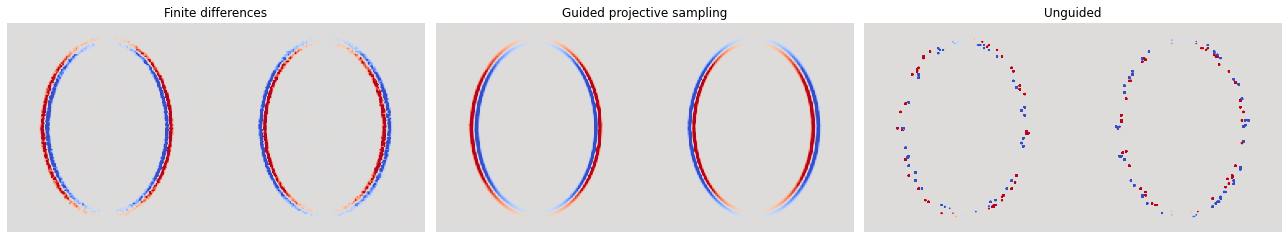

In [10]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

fig, axx = plt.subplots(1, 3, figsize=(18, 8))
vlim = dr.max(dr.abs(img_fd))[0] * 1
images = [img_fd, img_guided, img_unguided]
titles = ["Finite differences", "Guided projective sampling", "Unguided"]
for i, ax in enumerate(axx):
    ax.imshow(np.sum(images[i], axis=2), cmap=cm.coolwarm, vmin=-vlim, vmax=vlim)
    ax.set_title(titles[i])
    ax.axis('off')
fig.tight_layout()
plt.show()

## Optimization

The previous section is not only meant to be a small educational introduction to the projective sampling integrators, it also allows us to establish good hyperparameters for our integrator. This can be critical in certain optimization problems as the quality of the gradients has a direct influence on the outcome of the task.

In [11]:
# Reset the circle to its initial position before starting the optimization.
params[key] = initial_control_points
params.update();

We can finally run our optimization! We don't introduce any new concepts here, with maybe the exception that we carefully remove the control points' radii from the set of differentiable parameters. 

In [12]:
integrator = mi.load_dict({
    'type': 'direct_projective',
    'sppc': 0,
    'sppp': 0,
    'sppi': 1024,
})

radii = dr.unravel(mi.Point4f, initial_control_points)[3]
opt = mi.ad.Adam(lr=1e-2)
opt[key] = params[key]

max_iter = 450 if 'PYTEST_CURRENT_TEST' not in os.environ else 5
for it in range(max_iter):
    control_points = dr.unravel(mi.Point4f, opt[key])
    control_points[3] = radii # Do not optimize the radius
    params[key] = dr.ravel(control_points)
    params.update()

    img = mi.render(scene, params=params, sensor=batch_sensor, integrator=integrator, seed=it)

    # L2 loss
    loss = dr.mean(dr.sqr(img - image_ref))
    dr.backward(loss)

    # Take a gradient step
    opt.step()

    # Log
    print(f"{it+1}/{max_iter} loss: {loss[0]:.6f}", end='\r')

We can have a look at the final state of our scene, and see how the curve was stretched and twisted into a seemingly random shape whilst still producing shadows matching our reference.

In [13]:
image_scene = mi.render(scene, spp=4096)
mi.Bitmap(image_scene)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 128],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 384 KiB of image data ]
]

Let's also have a closer look at the shadows. They don't match perfectly - this problem is fairly ambiguous and without any sort of regularization it is quite easy to make "knots" in the curve which are hard to recover from.

The point of this is tutorial is to focus on projective integrators -- if you want to play with shadow art with your own reference images, it is recommended to add gradient preconditioning to the pipeline, add regularization to curve smoothness, and gradually give the curve more freedom to move around. This will help avoid getting stuck in local minima.

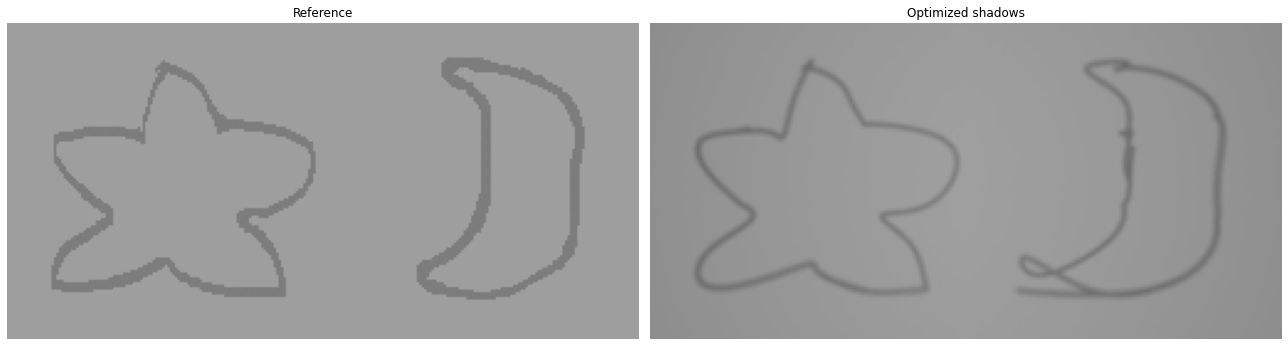

In [14]:
image_final = mi.render(scene, sensor=batch_sensor, spp=4096)
mi.Bitmap(image_final)

fig, axx = plt.subplots(1, 2, figsize=(18, 8))
images = [image_ref, image_final]
titles = ["Reference", "Optimized shadows"]
for i, ax in enumerate(axx):
    ax.imshow(mi.util.convert_to_bitmap(images[i]))
    ax.set_title(titles[i], fontsize=12)
    ax.axis('off')
fig.tight_layout()
plt.show()

## See also

- [<code>batch</code> plugin](https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_sensors.html#batch-sensor-batch)
- [<code>direct_projective</code> plugin](https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#direct-illumination-projective-sampling-direct-projective)
- [<code>prb_projective</code> plugin](https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#projective-sampling-path-replay-backpropagation-prb-prb-projective)